### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2018 ###

# "Will I Graduate?" An optimal Course Planner #

#### Michael Fernandes (mfernandes2@wisc.edu), Prasanna Venkatesh Ramadas (pramadas@wisc.edu), Elisa Ou (elisa.ou@wisc.edu), and Krishnan Rajagopalan (krajagopalan@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
  1. [Variables](#2.A.-Variables)
  1. [Constraints](#2.B.-Constraints)
  1. [Models](#2.C.-Models)
      1. [Tuition fee (dicrete function)](#2.C.a-Tuition)
      1. [A Toy Example of Modeling Average](#2.C.b-A-toy-example-of-modeling-average)
      1. [GPA (weighted average)](#2.C.c-GPA)
      1. [Knowledge Gain](#2.C.d-Knowledge-Gain)
      1. [Minimal Difficulty](#2.C.e-Minimal-Difficulty)
1. [Solution](#3.-Solution)
1. [Results and Discussion](#4.-Results-and-discussion)
    1. [Regularization](#4.A.-Regularization:-picking-the-best-among-optimal-solutions)
    1. [Thanks to Gurobi](#4.B.-Thanks-to-Gurobi)
    1. [Limitations of the model](#4.C.-Limitation-of-the-model)
    
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

"Art is long. Life is short". The University of Wisconsin-Madison offers an overwhelming number of interesting courses. Michael is amazed and wants to take all the best courses that would make him an expert in his domain. Elisa has been a top-performing student since her high school and would want to take those only courses that make her GPA as high as possible. She does not want to risk her GPA. Prasanna wants to put the least effort towards his degree and would rather spend the rest of his time partying. And there is Krishnan who is a mix of the three. This is just a sample space of any student who wishes to pursue Graduate studies.

We propose to design a student-friendly course planner that outputs an optimal schedule based on his/her preferences to graduate. The data used in our project is taken from the course list offered by CS department at UW-Madison (https://www.cs.wisc.edu/courses/list).
We model the problem as a mixed-integer linear program (MILP). Though the objectives to graduate are different for every person, we assume that every student's objective falls into one of the following categories :
* Maximize grade point average 
* Graduate by choosing courses of minimum difficulty 
* Graduate by spending minimum tuition fees 
* Graduate with maximum knowledge in his/her's area of interest 

The motivation for this problem comes from the scheduling problem studied in class. We propose to provide the optimal schedule based on the student's objective. 
The general problem setting is as follows:

* Complete the number of credits needed to graduate.
* Courses are numbered 200 through 900. Courses numbered 700 through 900 are core credit courses and the rest are non-core credits.
* Every course is associated with a fixed number of credits. Credits vary from 1 to 6.
* Courses are offered only in Spring or Fall semester or both. 
* The university demands that atleast 50 percent of the credits should be core credits. 

Here is a toy sample of the data which we used intially to conduct tests and verify our algorithms 


| code|Prerequisites| AI| Systems| PL |Credits |Expected GPA|
| ------------- |:-------------:| -----:|-----:|-----:|---------:|
| 300| -    |0    |0.5   |1   |3  |2.9
| 524| 300  | 0.5 |0     |0   |3  |3.4
| 532| 300  |2    |0     |0   |3  |3.5
| 240| -    | 0   |0     |0.5 |3  |2.8
|540 | 240  |1    |0     |0   |3  |3.25
|760 |540  |2     |0     |0   |3  |3.7
Also, since each couse has it's own schedule, we made a table consisting of the schedule of each of the courses. We do this, so that courses selected by our model do not have overlaping schedules 

| code|Monday|Tuesday| Wenesday|Thursday|Friday|Start Time|End Time|
| ------------- |:-------------:| -----:|-----:|-----:|---------:|
| 300| 1  | 0  |0     |0  | 0|8    |11
| 524| 0  | 1  |0     |1  |0 |1    |2.55
| 532| 1  | 0  |1     |0  |0 |11   |12.15
| 240| 0  | 1  |0     |1  |0 |2.3  |3.45
|540 | 1  |0   |1     |0  |1 |8.5  |9.40
|760 | 1  |0   |1     |0  |0 |1    |2.15

## 2. Mathematical model ##

We use the MILP model to solve the problem. The following sections discuss the variables, constraints and the objective functions present in each of the models. 

We have used different model instances for different objectives. As stated above, we consider multiple objectives as each student might want to optimize the course schedule according to his/her interests and goals. 

### 2.A. Variables
We define several variables to represent whether a course is taken:

$\mathbf{z}$ is a boolean vector of size $N$, where $N$ denotes total number of courses offered by the Computer Science department for both the Fall and Spring semesters: 

$$\mathbf{z}_i= \begin{cases} 
      1 & \text{course $i$ is taken} \\
      0 & \text{otherwise}
   \end{cases}
$$
$\mathbf{zj}$ is a boolean vector of size $N$: 
$$\mathbf{zj}_i= \begin{cases} 
      1 & \text{course $i$ is taken in the $j^{th}$ semester} \\
      0 & \text{otherwise}
   \end{cases}
$$

### 2.B. Constraints
In this part, we provide with the details of the common constraints that are present in all the models. These include time conflicts, prerequisites and credits required for graduation.

#### 2.B.a. Time Conflicts
In our schedule data table, for each course we have the semester, the day, the start time and the end time. Based on this, we construct a conflict matrix $\mathbf{C} \in \mathbb{R}^{N \times N}$, in which: 
$$\mathbf{C}_{ij}= \begin{cases} 
      1 & \text{if course $i$ and $j$ is overlapping} \\
      0 & \text{otherwise}.
   \end{cases}
$$

To fill in this matrix, first we check if the two courses $i$ and $j$ are offered in the same semester, same day and whether their time is overlapping.

* Semester offered: For each course, we assign $\{-1,1,0\}$ to indicate in which semester the course is offered.

$$\mathbf{s}_{i}= \begin{cases} 
      1 & \text{if course $i$ is offered in fall only} \\
      -1 & \text{if course $i$ is offered in spring only} \\
      0 & \text{if course $i$ is offered both in fall and spring}.
   \end{cases}
$$

We do not take summer semester into consideration.

* Day offered: For all courses, we have a matrix $\mathbf{D}_{ik},i \in courses, k \in \{1,2,...,5\}$ indicating whether course $i$ is scheduled on day $k$ or not.

$$\mathbf{D}_{ik}= \begin{cases} 
      1 & \text{if course $i$ is offered on day $k$} \\
      0 & \text{otherwise}.
   \end{cases}
$$
We do not consider weekend classes.

* Time schedule: If they are scheduled at the same day, we then consider if $i$ and $j$ are overlapping, if:

$$t^i_{start} < t^j_{end}\quad and\quad t^j_{start} < t^i_{end}$$

Here $t^i_{start}$ denotes the start time of course $i$ and $t^i_{end}$ denotes the end time.

To combine this three conditions:
$$\mathbf{s}_{i}\mathbf{s}_{j}\geq 0\;\&\;\mathbf{D}_{ik}\mathbf{D}_{jk}=1\; \& \; (t^i_{start}-t^j_{end})(t^j_{start}-t^i_{end})>0\; \rightarrow \mathbf{C}_{ij}=1$$

* $\mathbf{s}_{i}.\mathbf{s}_{j}\geq 0$ would be true only if both the courses ${s}_{i}$ and ${s}_{j}$ were offered in Fall or if both courses were offered in Spring or if both courses were offered throughout the year or if either one of the courses was offered throughout the year while the other one was offered in only one of the semesters.

* $\mathbf{D}_{ik}\mathbf{D}_{jk}=1\;$ would be true only if both the courses ${s}_{i}$ and ${s}_{j}$ were offered on the same day $k$.

* $(t^i_{start}-t^j_{end})(t^j_{start}-t^i_{end})>0\;$ only if the two courses overlap with respect to the time of the day.

#### 2.B.b. Prerequisites 
This is same as the real life settings i.e. for a particular course we have one or two prerequisites. So for each course each semester, we check if the prerequisites of this course were taken in previous semesters or not. If not, we can not take this course in the current semester.

We model te prerequisites as follows. Let us for example consider courses and their prerequisites for semester 3 :

$${z3}_j >= {z3}_i$$
where course $j$ is in the prerequisite list of course $i$. This means that if the prerequisite course is not taken i.e. ${z3}_j = 0$ then the current course cannot be taken i.e. ${z3}_i = 0$.

Also, we have an additonal constraint that both the course and it's prerequisite cannot be taken in the same semester.
$${z3}_j + {z3}_i <= 1$$

#### 2.B.c. Credits
* Total credits: a student needs at least 30 credits to graduate.
* Credits per semester: we do not explicitly set a minimum credit for each semester. Instead, we require a student taking at least one course per semester
* Core credits: We define any courses above 700 level as core courses. And to simplify our model, we add a constraint that a student needs at least 3 credits of core courses to graduate.

### 2.C. Models
#### 2.C.a Tuition
We obtain tuition fee data from [UW-Madison website](https://registrar.wisc.edu/tuitionrates/).

| Credits        | Tuition  | Segregated |Total |
| ------------- |:-------------:| -----:|-----:|
| 1     | \$1,601.29      |\$97.89 |\$1699.18 |
| 2     | \$3,177.08      | \$170.28 |\$3347.36 |
| 3 | \$4,752.87      | \$242.67 |\$4995.54 |
| 4 to 7 | \$6,328.66      | \$315.06 |\$6643.72 |
| 8 | \$7,832.06      | \$315.06 |\$8147.12 |
| 9+ | \$9,335.46      | \$315.06 |\$9650.52 |

Total fee is a discrete-valued function. 

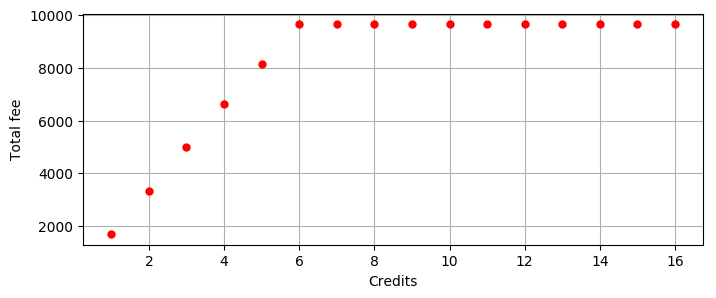

In [1]:
using PyPlot
credits_per_semester = 1:16;
total_fee_per = [1699.18,3347.36,4995.54,6643.72,8147.12,9650.52,9650.52,9650.52,9650.52,
9650.52,9650.52,9650.52,9650.52,9650.52,9650.52,9650.52]; 

figure(figsize=(8,3))
plot( credits_per_semester, total_fee_per, "r.", markersize=10)
xlabel("Credits")
ylabel("Total fee")
grid()

Model this function using SOS1 constraints, we have:

$(\mathbf{c}_i,\mathbf{f}_i)$, i = 1,2,...,16 be admissible (x,y) pairs, in which $\mathbf{c}$ denotes credit taken per semster and $\mathbf{f}$ denotes corresponding fees.
And for each semster, we have a SOS1 constraint for variable $\mathbf{\lambda}$. Therefore, our model is

$$credits = \sum_{i=1}^{16} \mathbf{c}_i \mathbf{\lambda}_i$$
$$fee = \sum_{i=1}^{16} \mathbf{f}_i \mathbf{\lambda}_i$$
$$\sum_{i=1}^{16} \mathbf{\lambda}_i=1,\; \lambda_i \geq 0$$

$${\lambda_1,...,\lambda_m}\; \mathrm{is\; SOS1}.$$
$credits$ is how many credits are taken this semster and $fee$ is the total tuition fee for this correspoding credits.

For speed consideration, we actually use the algebraic forumlation instead, which is:
$$credits = \sum_{i=1}^{16} \mathbf{c}_i \mathbf{\lambda}_i$$
$$fee = \sum_{i=1}^{16} \mathbf{f}_i \mathbf{\lambda}_i$$
$$\sum_{i=1}^{16} \mathbf{\lambda}_i=1$$

$$\lambda_i,...,\lambda_m \in \{0,1\}.$$


#### 2.C.b A toy example of modeling average
To lead to model GPA, first we need to consider how to model the average of several value if they are not all taken.
Let's consider a simple optimization problem first. 
Choose several elements in a set so that the number of elements plus the average of chosen elements are maximized.
That is

$$
\begin{aligned}
\underset{\mathbf{x}}{\text{maximize}}\qquad& \sum_{i=1}^n \mathbf{x}_i - \frac{\sum_{i=1}^n \mathbf{x}_i \mathbf{a}_i}{\sum_{i=1}^n \mathbf{x}_i} \\
\text{subject to:}\qquad& \mathbf{x}_i \in \{0,1\} && i=1,\dots,n\\
\end{aligned}
$$

$\mathbf{a}_i$ is the $i^{th}$ element in a set of number $\mathbf{a}$.
This problem seems easy at first glance. However, we have variables in our demominator, which is neither a linear problem nor a quadratic problem. It is an integer problem with variables in the demominator. 

We come up with two ways to solve this problem. One is using logic constraints with extra logic variables to get a precise results. The other is to use infinity norm or 2-norm to approximate the average.

* **Using 2-norm/infinity norm to approximate the average:** In this method, we try to introduce a new variable $\mathbf{wt}$ to explicitly assign weights to $\mathbf{a}$. To get the average of all the selected elements, we want weights to be equal for each selected element. We also know that 2-norm and infinity norm have the effect of smoothing. So we add a penalty term to the original objective function. Here $p$ is 2 or infinity.

\begin{aligned}
\underset{\mathbf{x},\mathbf{wt}}{\text{maximize}}\qquad& \sum_{i=1}^n \mathbf{x}_i - \sum_{i=1}^n \mathbf{wt}_i \mathbf{a}_i - \lambda \|\mathbf{wt}\|_p \\
\text{subject to:}\qquad
                  &\sum_{i=1}^n \mathbf{wt}_i = 1 \\
                  & \mathbf{wt}_i \geq (1-\mathbf{x}_i)+\epsilon \mathbf{x}_i && i=1,\dots,n\\
                  &\mathbf{wt}_i \geq 0 && i=1,\dots,n \\
                  & \mathbf{x}_i \in \{0,1\} && i=1,\dots,n\\
\end{aligned}



In [2]:
a = [100,2,3,4,5,6,7,8];

In [3]:
# 2-norm 
using JuMP,Gurobi
lmd=100;
m1 = Model(solver=GurobiSolver(OutputFlag = 0))

@variable(m1, x[1:8],Bin)
@variable(m1, wt[1:8]>=0)

@constraint(m1, sum(wt[i] for i in 1:8)==1)

# for i = 1:8
     # @constraint(m1, wt[i]>=(1-x[i])+0.01*x[i])
# end

@objective(m1, Max, sum(x[i]-a[i]*wt[i] for i in 1:8)- lmd*sum(wt.^2))
solve(m1)
println("The optimal value is: ", getobjectivevalue(m1))
println("The optimal x value is: ", getvalue(x))
println("The weights given is: ",getvalue(wt))

Academic license - for non-commercial use only
The optimal value is: -11.215714290371805
The optimal x value is: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
The weights given is: [7.01132e-11, 0.157857, 0.152857, 0.147857, 0.142857, 0.137857, 0.132857, 0.127857]


In [4]:
# Infinity norm
using JuMP,Gurobi
lmd=100;

m2 = Model(solver=GurobiSolver(OutputFlag = 0))

@variable(m2, x[1:8],Bin)
@variable(m2, wt[1:8]>=0)
@variable(m2, r)
@constraint(m2, sum(wt[i] for i in 1:8)==1)
@constraint(m2, wt .<= r )
@constraint(m2, -r .<= wt )

@objective(m2, Max, sum(x[i]-a[i]*wt[i] for i in 1:8)-lmd*r)
solve(m2)
println("The optimal value is: ", getobjectivevalue(m2))
println("The optimal x is: ", getvalue(x))
println("The weights given is: ",getvalue(wt))

Academic license - for non-commercial use only
The optimal value is: -11.285714285714288
The optimal x is: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
The weights given is: [0.0, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857]


In [5]:
# Infinity norm
using JuMP,Gurobi
lmd=100;

m2 = Model(solver=GurobiSolver(OutputFlag = 0))

@variable(m2, x[1:8],Bin)
@variable(m2, wt[1:8]>=0)
@variable(m2, r)
@constraint(m2, sum(wt[i] for i in 1:8)==1)
@constraint(m2, wt .<= r )
@constraint(m2, -r .<= wt )

@objective(m2, Max, sum(x[i]-a[i]*wt[i] for i in 1:8)-lmd*sum(r))
solve(m2)
println("The optimal value is: ", getobjectivevalue(m2))
println("The optimal x is: ", getvalue(x))
println("The weights given is: ",getvalue(wt))

Academic license - for non-commercial use only
The optimal value is: -11.285714285714288
The optimal x is: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
The weights given is: [0.0, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857]


Here we can conclude that, by choosing a big $\lambda$, we have equal weights for some elements, but not exactly for every selected elements. This method tends to assign small weights for big elements as we are minimizing the average.

* **Using extra logic variables:** The failure of penalizing method forces us to shift to something else. We come up with another method based on the logic behind this.  

<center>If $\mathbf{x}_i=1$ and $\mathbf{x}_j=1$ then $\mathbf{wt}_i=\mathbf{wt}_j$</center>

This means that if we have selected two items i.e. ${x}_i = 1$ and ${x}_j = 1$ then we are going to assign the two items the same weights. In this way if we consider every pair of items ${x}_i$ and ${x}_j$ and assign them equal weights whenever both of them are equal to 1, then all items with a value 1 get assigned the same weight. By adding the constraint that the sum of these weights must be 1, we ensure that each item gets multiplied with $\frac{1}{N}$ where $N$ is the number of ${x}_i$'s assigned a value 1.

However, we cannot model this constrait in a straightforward way. Inspired by 
> $(P_1\wedge P_2)\Rightarrow P_3$ can be transfered into $\delta_1+\delta_2\leq1+\delta_3$

in [Lecture 20](#http://www.laurentlessard.com/teaching/cs524/slides/20%20-%20logic%20constraints%20and%20integer%20variables.pdf), we add an extra logic variable $\mathbf{d}\in\mathbb{R}^{n\times n}$, where:
$$\mathbf{d}_{ij}= \begin{cases} 
      1 & \mathbf{x}_i=1\, \&\, \mathbf{x}_j=1 \\
      0 & \text{otherwise.}
   \end{cases}
$$
So we have 
<center>If $\mathbf{x}_i = 1$ and $\mathbf{x}_j = 1$, then $\mathbf{d}_{ij} = 1$;</center>
<center>If $\mathbf{d}_{i,j} = 1$, then $\mathbf{wt}_i=\mathbf{wt}_j $.</center>

Based on that, we build our model as following:

\begin{aligned}
\underset{\mathbf{x},\mathbf{wt},\mathbf{d}}{\text{maximize}}\qquad& \sum_{i=1}^n \mathbf{x}_i - \sum_{i=1}^n \mathbf{wt}_i \mathbf{a}_i  \\
\text{subject to:}\qquad
                  &\sum_{i=1}^n \mathbf{wt}_i = 1 \\
                  & \mathbf{x}_i + \mathbf{x}_j \leq 1 + \mathbf{d}_{ij} && i,j=1,\dots,n\\
                  & -(1-\mathbf{d}_{ij}) \leq \mathbf{wt}_i -\mathbf{wt}_j && i,j=1,\dots,n\\
                  & 1-\mathbf{d}_{ij} \geq \mathbf{wt}_i-\mathbf{wt}_j && i,j=1,\dots,n\\
                  & 0 \leq \mathbf{wt}_i \leq \mathbf{x}_i && i=1,\dots,n \\
                  & \mathbf{x}_i \in \{0,1\} && i=1,\dots,n\\
                  & \mathbf{d}_{ij} \in \{0,1\} && i,j=1,\dots,n\\
\end{aligned}

In [6]:
# Logic variables
using JuMP,Gurobi

m3 = Model(solver=GurobiSolver(OutputFlag = 0))

@variable(m3, x[1:8],Bin)
@variable(m3, wt[1:8]>=0)
@variable(m3, q[1:8,1:8],Bin)

@constraint(m3, sum(wt[i] for i in 1:8)==1)

for i in 1:8
        @constraint(m3,wt[i] <= x[i]) # instead of @constraint(m3, wt[i]>=(1-x[i])+0.01*x[i])
    for j in 1:8
        @constraint(m3,x[i]+x[j] <= 1+q[i,j])
        @constraint(m3,-(1-q[i,j]) <= wt[i]-wt[j])
        @constraint(m3,(1-q[i,j]) >= wt[i]-wt[j])
    end
end

@objective(m3, Max, sum(x[i]-a[i]*wt[i] for i in 1:8))
solve(m3)
println("The optimal value is: ", getobjectivevalue(m3))
println("The optimal x is: ", getvalue(x))
println("The weights given is: ",getvalue(wt))
getvalue(q)

Academic license - for non-commercial use only
The optimal value is: 1.9999999999999993
The optimal x is: [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
The weights given is: [0.0, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857]


8×8 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

As expected, this yields reasonable results. 

#### 2.C.c GPA
To calculate GPA, we need to model weighted mean:
$$ \mathbf{w}_i = \frac{\mathbf{c}_i}{\sum_{i \in courses} \mathbf{c}_i},$$

$$  gp = \sum_{i \in courses} \mathbf{w}_i \mathbf{g}_i,
$$
where $\mathbf{c}_i$ is number of credits for course $i$, $\mathbf{g}_i$ is the expected GPA for course $i$, $courses$ is the set of all the courses offered.
This is not very different from the toy model we solved in previous section, besides it is weighted by credits of the course.
We add another variable in order to build the weighted mean model.

$\mathbf{D}$ is a boolean matrix of size $N \times N$: 
$$\mathbf{D}_{ij}= \begin{cases} 
      1 & \text{both course $i$ and course $j$ are taken} \\
      0 & \text{otherwise}
   \end{cases}
$$

The logic behind this is:

If $\mathbf{z}_i = 1$ and $\mathbf{z}_j = 1$, then $\mathbf{D}_{ij} = 1$;

If $\mathbf{D}_{i,j} = 1$, then $\mathbf{w}_i \mathbf{c}_j=\mathbf{w}_j \mathbf{c}_i$.

Add several constraints based on the logic:
$$\mathbf{z}_i + \mathbf{z}_j \leq 1 + \mathbf{D}_{ij},$$

 
$\mathbf{w}_i$ cannot exceed 1, and the max credit for one course is 6. So we use -6/6 as lower/upper bound.

$$-6(1-\mathbf{D}_{ij}) \leq \mathbf{w}_i \mathbf{c}_j-\mathbf{w}_j \mathbf{c}_i, $$

$$ 6(1-\mathbf{D}_{ij}) \geq \mathbf{w}_i \mathbf{c}_j-\mathbf{w}_j \mathbf{c}_i, $$

Also all entries in $\mathbf{w}$ should sum up to 1:
$$
   \sum_{i \in courses} \mathbf{w}_i = 1.
$$

#### 2.C.d Knowledge Gain

For each course, we assign gain of this course for several different domains. 
Our objective function for knowledge gain of domain $j$ is:
$$\sum_{i \in courses} \mathbf{z}_i . score_{ij},$$
where $score_{ij}$ is the score for course $i$ in domain $j$.

#### 2.C.e Minimal Difficulty

For each course, we assign difficulty of this course. 
Our objective function for knowledge gain of domain $j$ is:
$$\sum_{i \in courses} \mathbf{z}_i . difficulty_{i},$$
where $difficulty_{i}$ is the difficulty for course $i$.

## 3. Solution ##

In [7]:
using JuMP,Cbc,Gurobi,Mosek
using NamedArrays

### Input the data and pre-processing 

In [8]:
raw = readcsv("g_data.csv"); 
schedule=readcsv("g_schedule.csv");
number_of_courses=80 # To test, enter a value between 1 and 80
(x,y) = size(raw)
(a,b) =size(schedule)

x_attributes = 2:8      # columns containing course attributes
y_courses = 2:number_of_courses+1          # rows containing course names

b_days=2:9

attributes = raw[1,x_attributes][:]   # the list of course attributes (convert to 1-D array)

courses = raw[y_courses,1][:]         # the list of courses (convert to 1-D array)
semester=schedule[y_courses,9][:]
semester_offered=Dict(zip(courses,semester))

pre=raw[y_courses,3][:]


for i in 1:length(pre)
   
    pre[i]=string(pre[i])
    if pre[i]!=""
    pre[i]=map(x->parse(Int,x), split(pre[i], ","))
        #print(typeof(pre[i]))
    else
        m=[]
        pre[i]=m
        
    end
    
end
pred = Dict(zip(courses,pre))


AI=raw[y_courses,4][:]
AI_score = Dict(zip(courses,AI))
Systems=raw[y_courses,5][:]
Systems_score = Dict(zip(courses,Systems))
credits=raw[y_courses,7][:]
no_credits=Dict(zip(courses,credits))
st=schedule[y_courses,7][:]
start_time=Dict(zip(courses,st))
et=schedule[y_courses,8][:]
end_time=Dict(zip(courses,et))
gpa=raw[y_courses,8][:]
exp_gpa=Dict(zip(courses,gpa));

days=schedule[1,2:6][:]                   # the list of days (convert to 1-D array)            
course_schedule=NamedArray(schedule[y_courses,2:6],(courses,days),("courses","days"));
#conflicts=NamedArray(schedule[y_courses,y_courses],(courses,courses),("courses","courses"))
conflicts=zeros(number_of_courses,number_of_courses)

core_credits=0;

###  Variables , constraints and expressions used throughout the model

In [9]:
m = Model(solver=GurobiSolver(OutputFlag = 0))
@variable(m, z[courses],Bin)  #boolean vector for all the courses
@variable(m, z1[courses],Bin) #boolean vector for semester 1 
@variable(m, z2[courses],Bin) #boolean vector for semester 2 
@variable(m, z3[courses],Bin) #boolean vector for semester 3 
@variable(m, z4[courses],Bin) #boolean vector for semester 4 
@variable(m, d[courses,courses],Bin) 
@variable(m, w[courses]>=0) 


# You should take a certain number of core credits
for i in 1:length(courses)
    if courses[i]>=700
       core_credits=core_credits+z[courses[i]]*credits[i]
    end
end
@constraint(m,core_credits>=15) # core constraint;

println()

### weight for every course towards GPA

In [10]:
for i in courses
     @constraint(m, w[i] <= z[i])
    for j in courses
        @constraint(m,z[i]+z[j] <= 1+d[i,j])
        @constraint(m,-6(1-d[i,j]) <= no_credits[j]*w[i]-no_credits[i]*w[j])
        @constraint(m,6(1-d[i,j]) >= no_credits[j]*w[i]-no_credits[i]*w[j])
    end
end

### Model of the conflict Matrix

In [11]:
for i in 1:length(courses) 
    for j in 1:length(courses)
        conflicts[i,j]=0
    end
end



for i in 1:length(courses) 
    for j in 1:length(courses)
        if i!=j
        for k in days
            if semester_offered[courses[i]]==semester_offered[courses[j]] || semester_offered[courses[i]]==0 || semester_offered[courses[j]]==0
            if course_schedule[i,k]==1 && course_schedule[j,k]==1
                   if ((start_time[courses[i]]-end_time[courses[j]])*(start_time[courses[j]]-end_time[courses[i]]))>0
                        #println(courses[i])
                        #println(courses[j])
                        conflicts[i,j]=1
                    
                    end
                
                end
            
            end
        end
        end
    end
end

### First Semester Courses

In [12]:
for i in courses
    

        for j in pred[i]
            @constraint(m, z1[j]>=z1[i])  # The prerequisites for the course should be taken in the previous semesters
            @constraint(m,z1[i]+z1[j]<=1) # Cannot take a course and its prerequisite in the same semester
            
            end
       end

for i in courses
        # Check if course is offered in the current semester or not
        @constraint(m,z1[i]*semester_offered[i]>=0)
end
@constraint(m,s1[i in 1:length(courses),j in 1:length(courses)],z1[courses[i]]*conflicts[i,j] +z1[courses[j]]*conflicts[i,j]<=1);
 

### Second Semester Courses

In [13]:
for i in courses
  
    
        for j in pred[i]
            @constraint(m, z1[j]>=z2[i])
            @constraint(m,z2[i]+z2[j]<=1)
            end
       
       end
for i in courses    
@constraint(m,z2[i]*semester_offered[i]<=0)
end
@constraint(m,s2[i in 1:length(courses),j in 1:length(courses)],z2[courses[i]]*conflicts[i,j] +z2[courses[j]]*conflicts[i,j]<=1);

### Third Semester Courses

In [14]:
for i in courses
  
    
        for j in pred[i]
            @constraint(m, z1[j]+z2[j]>=z3[i])
            @constraint(m,z3[i]+z3[j]<=1)
            end
       
       end

for i in courses    
@constraint(m,z3[i]*semester_offered[i]>=0)
end
@constraint(m,s3[i in 1:length(courses),j in 1:length(courses)],z3[courses[i]]*conflicts[i,j] +z3[courses[j]]*conflicts[i,j]<=1);

### Fourth Semester Courses

In [15]:
for i in courses
  
    
        for j in pred[i]
            @constraint(m, z1[j]+z2[j]+z3[j]>=z4[i])
            @constraint(m,z4[i]+z4[j]<=1)
            end
       
       end

for i in courses    
@constraint(m,z4[i]*semester_offered[i]<=0)
end
@constraint(m,s4[i in 1:length(courses),j in 1:length(courses)],z4[courses[i]]*conflicts[i,j] +z4[courses[j]]*conflicts[i,j]<=1);

### A course can only be taken once, and atleast one course should be taken per semster

In [16]:
#A course can be taken only once
for i in courses
    @constraint(m,z1[i]+z2[i]+z3[i]+z4[i]==z[i])
end


 #Atleast one course should be taken in a semester
@constraint(m,sum(z1)>=1)
@constraint(m,sum(z2)>=1)
@constraint(m,sum(z3)>=1)
@constraint(m,sum(z4)>=1)
;

## Objective for minimize tuition fee

In [17]:
credits_per_semester = 1:16; #credits can not exceed 16 for one single semester
total_fee_per = [1699.18,3347.36,4995.54,6643.72,8147.12,9650.52,9650.52,9650.52,9650.52,
9650.52,9650.52,9650.52,9650.52,9650.52,9650.52,9650.52]; #corresponding fee
# total_fee_per = [4000.18,3347.36,4995.54,6643.72,8147.12,9650.52,9650.52,9650.52,9650.52,
# 9650.52,9650.52,9650.52,9650.52,9650.52,9650.52,9650.52]; #corresponding fee

In [18]:
@variable(m,0<=λ1[1:16]<=1)
@variable(m,0<=λ2[1:16]<=1)
@variable(m,0<=λ3[1:16]<=1)
@variable(m,0<=λ4[1:16]<=1)
@variable(m,λ1[1:16],Bin)
@variable(m,λ2[1:16],Bin)
@variable(m,λ3[1:16],Bin)
@variable(m,λ4[1:16],Bin)

# addSOS1(m,λ1)
# addSOS1(m,λ2)
# addSOS1(m,λ3)
# addSOS1(m,λ4)
#for semester 1
@expression(m,credits_obtained1,sum(z1[courses[i]]*credits[i] for i in 1:length(courses)))
@constraint(m,sum(λ1[i] for i in 1:16)==1)
@constraint(m,sum(credits_per_semester[i]*λ1[i] for i in 1:16)==credits_obtained1)
@expression(m,total_fee1,sum(total_fee_per[i]*λ1[i] for i in 1:16))
#for semester 2
@expression(m,credits_obtained2,sum(z2[courses[i]]*credits[i] for i in 1:length(courses)))
@constraint(m,sum(λ2[i] for i in 1:16)==1)
@constraint(m,sum(credits_per_semester[i]*λ2[i] for i in 1:16)==credits_obtained2)
@expression(m,total_fee2,sum(total_fee_per[i]*λ2[i] for i in 1:16))
#for semester 3
@expression(m,credits_obtained3,sum(z3[courses[i]]*credits[i] for i in 1:length(courses)))
@constraint(m,sum(λ3[i] for i in 1:16)==1)
@constraint(m,sum(credits_per_semester[i]*λ3[i] for i in 1:16)==credits_obtained3)
@expression(m,total_fee3,sum(total_fee_per[i]*λ3[i] for i in 1:16))
#for semester 4
@expression(m,credits_obtained4,sum(z4[courses[i]]*credits[i] for i in 1:length(courses)))
@constraint(m,sum(λ4[i] for i in 1:16)==1)
@constraint(m,sum(credits_per_semester[i]*λ4[i] for i in 1:16)==credits_obtained4)
@expression(m,total_fee4,sum(total_fee_per[i]*λ4[i] for i in 1:16))

#for all semsters
@expression(m,credits_obtained,credits_obtained1+credits_obtained2+credits_obtained3+credits_obtained4)
@constraint(m,credits_obtained>=30);

@objective(m,Min,total_fee1+total_fee2+total_fee3+total_fee4)

@time solve(m)
println(getobjectivevalue(m))
println(getobjectivevalue(m))
println(getvalue(credits_obtained))

println("Your courses for Fall 2017")
for i in courses
    if getvalue(z1[i])==1
        println(i)
    end
end
println("Credits: ",getvalue(credits_obtained1))
println("Tuition fee: ",getvalue(total_fee1))
println("Your courses for Spring 2018:")
for i in courses
    if getvalue(z2[i])==1
        println(i)
    end
end
println("Credits: ",getvalue(credits_obtained2))
println("Tuition fee: ",getvalue(total_fee2))
println("Your courses for Fall 2018:")
for i in courses
    if getvalue(z3[i])==1
        println(i)
    end
end
println("Credits: ",getvalue(credits_obtained3))
println("Tuition fee: ",getvalue(total_fee3))
println("Your courses for Spring 2019:")
for i in courses
    if getvalue(z4[i])==1
        println(i)
    end
end
println("Credits: ",getvalue(credits_obtained4))
println("Tuition fee: ",getvalue(total_fee4))

Academic license - for non-commercial use only
  7.397184 seconds (3.45 M allocations: 183.349 MiB, 2.17% gc time)
22699.4
22699.4
32.0
Your courses for Fall 2017
300
770
302
681
899
Credits: 15.0
Tuition fee: 9650.52
Your courses for Spring 2018:
202
525
790
704
880
Credits: 15.0
Tuition fee: 9650.52
Your courses for Fall 2018:
368
Credits: 1.0
Tuition fee: 1699.18
Your courses for Spring 2019:
304
Credits: 1.0
Tuition fee: 1699.18


## Objective for maximizing the GPA

In [19]:
@expression(m,credits_obtained,sum(z[courses[i]]*credits[i] for i in 1:length(courses)))
@constraint(m,credits_obtained>=30);
@constraint(m, sum(w) == 1)
@expression(m,val,sum((z[i]-w[i])*(z[i]-w[i]) for i in courses)) 
@expression(m, gp,(sum(w[i] * exp_gpa[i] for i in courses)))
@expression(m,true_gp,(sum(z[i]*exp_gpa[i] for i in courses)))


@objective(m,Max,gp)

@time solve(m)
println(getvalue(gp))
println(getvalue(credits_obtained))

println("Your courses for Fall 2017")
for i in courses
    if getvalue(z1[i])==1
        println(i)
    end
end
println("Your courses for Spring 2018:")
for i in courses
    if getvalue(z2[i])==1
        println(i)
    end
end
println("Your courses for Fall 2018:")
for i in courses
    if getvalue(z3[i])==1
        println(i)
    end
end
println("Your courses for Spring 2019:")
for i in courses
    if getvalue(z4[i])==1
        println(i)
    end
end

  9.702613 seconds (1.79 k allocations: 2.977 MiB)
3.7912903328980763
31.0
Your courses for Fall 2017
300
681
Your courses for Spring 2018:
838
880
Your courses for Fall 2018:
899
Your courses for Spring 2019:
298
402
525
790
570
704


### Objective for maximizing the gain from courses

In [20]:
@expression(m, domain_score, sum(z[i]*AI_score[i] for i in courses)) 
@objective(m, Max, domain_score)     # total duration is start time of last task + duration of last task.
@time solve(m)
println(getvalue(gp))
println(getvalue(credits_obtained))

println("Your courses for Fall 2017")
for i in courses
     if getvalue(z1[i])==1
         println(i)
     end
 end
 println("Your courses for Spring 2018:")
 for i in courses
     if getvalue(z2[i])==1
         println(i)
     end
 end
 println("Your courses for Fall 2018:")
 for i in courses
     if getvalue(z3[i])==1
         println(i)
     end
 end
 println("Your courses for Spring 2019:")
 for i in courses
     if getvalue(z4[i])==1
        println(i)
     end
end

  3.231638 seconds (76 allocations: 2.884 MiB)
3.5008333333333344
60.0
Your courses for Fall 2017
300
200
202
302
368
681
Your courses for Spring 2018:
240
270
400
838
471
Your courses for Fall 2018:
532
540
770
539
899
Your courses for Spring 2019:
524
760
790
513
558


### Objective to graduate with minimal difficulty

In [21]:
@expression(m, difficulty_score, sum(z[i]*(i/700+i/500+i/300) for i in courses)) 
@objective(m, Min, difficulty_score)     # total duration is start time of last task + duration of last task.
@time solve(m)
println(getvalue(gp))
println(getvalue(credits_obtained))

println("Your courses for Fall 2017")
for i in courses
     if getvalue(z1[i])==1
         println(i)
     end
 end
 println("Your courses for Spring 2018:")
 for i in courses
     if getvalue(z2[i])==1
         println(i)
     end
 end
 println("Your courses for Fall 2018:")
 for i in courses
     if getvalue(z3[i])==1
         println(i)
     end
 end
 println("Your courses for Spring 2019:")
 for i in courses
     if getvalue(z4[i])==1
        println(i)
     end
end

  1.054456 seconds (76 allocations: 2.884 MiB, 1.04% gc time)
3.3360000000000003
30.0
Your courses for Fall 2017
300
240
202
Your courses for Spring 2018:
536
790
704
Your courses for Fall 2018:
706
200
703
Your courses for Spring 2019:
701


In [22]:
@expression(m, difficulty_score, sum(z[i]*(i/700+i/500+i/300) for i in courses)) 
@objective(m, Min, 0.1*difficulty_score -0.9*domain_score+0.1*(total_fee1+total_fee2+total_fee3+total_fee4)-0.5*gp)     # total duration is start time of last task + duration of last task.
solve(m)
println(getvalue(gp))
println(getvalue(credits_obtained))

println("Your courses for Fall 2017")
for i in courses
     if getvalue(z1[i])==1
         println(i)
     end
 end
 println("Your courses for Spring 2018:")
 for i in courses
     if getvalue(z2[i])==1
         println(i)
     end
 end
 println("Your courses for Fall 2018:")
 for i in courses
     if getvalue(z3[i])==1
         println(i)
     end
 end
 println("Your courses for Spring 2019:")
 for i in courses
     if getvalue(z4[i])==1
        println(i)
     end
end

3.636250000000003
32.0
Your courses for Fall 2017
300
770
302
790
899
Your courses for Spring 2018:
304
Your courses for Fall 2018:
368
Your courses for Spring 2019:
270
681
838
513
880


## 4. Results and discussion ##

### 4.A. Regularization: picking the best among optimal solutions
We get an optimal solution for the stated objectives and the four objectives are totally independent. We observe that there could be more than one optimal solution for a given objective. In such cases, we could use regularization to pick the best solution. For example, among multiple solutions that give the same tuition fee, we could pick the one that gives the maximum GPA as below :

In [23]:
@objective(m,Min,total_fee1+total_fee2+total_fee3+total_fee4-gp)

@time solve(m)
println(getobjectivevalue(m))
println(getobjectivevalue(m))
println(getvalue(credits_obtained))

println("Your courses for Fall 2017")
for i in courses
    if getvalue(z1[i])==1
        println(i)
    end
end
println("Credits: ",getvalue(credits_obtained1))
println("Tuition fee: ",getvalue(total_fee1))
println("Your courses for Spring 2018:")
for i in courses
    if getvalue(z2[i])==1
        println(i)
    end
end
println("Credits: ",getvalue(credits_obtained2))
println("Tuition fee: ",getvalue(total_fee2))
println("Your courses for Fall 2018:")
for i in courses
    if getvalue(z3[i])==1
        println(i)
    end
end
println("Credits: ",getvalue(credits_obtained3))
println("Tuition fee: ",getvalue(total_fee3))
println("Your courses for Spring 2019:")
for i in courses
    if getvalue(z4[i])==1
        println(i)
    end
end
println("Credits: ",getvalue(credits_obtained4))
println("Tuition fee: ",getvalue(total_fee4))

  5.370200 seconds (76 allocations: 2.884 MiB)
22695.688387096776
22695.688387096776
31.0
Your courses for Fall 2017
300
770
302
790
899
Credits: 15.0
Tuition fee: 9650.52
Your courses for Spring 2018:
402
681
838
570
880
Credits: 14.0
Tuition fee: 9650.52
Your courses for Fall 2018:
304
Credits: 1.0
Tuition fee: 1699.18
Your courses for Spring 2019:
368
Credits: 1.0
Tuition fee: 1699.18


To pick a solution that yields the best domain score among all solutions with the same tuition cost :

In [24]:
@objective(m,Min,total_fee1+total_fee2+total_fee3+total_fee4-domain_score)

@time solve(m)
println(getobjectivevalue(m))
println(getobjectivevalue(m))
println(getvalue(credits_obtained))

println("Your courses for Fall 2017")
for i in courses
    if getvalue(z1[i])==1
        println(i)
    end
end
println("Credits: ",getvalue(credits_obtained1))
println("Tuition fee: ",getvalue(total_fee1))
println("Your courses for Spring 2018:")
for i in courses
    if getvalue(z2[i])==1
        println(i)
    end
end
println("Credits: ",getvalue(credits_obtained2))
println("Tuition fee: ",getvalue(total_fee2))
println("Your courses for Fall 2018:")
for i in courses
    if getvalue(z3[i])==1
        println(i)
    end
end
println("Credits: ",getvalue(credits_obtained3))
println("Tuition fee: ",getvalue(total_fee3))
println("Your courses for Spring 2019:")
for i in courses
    if getvalue(z4[i])==1
        println(i)
    end
end
println("Credits: ",getvalue(credits_obtained4))
println("Tuition fee: ",getvalue(total_fee4))

  4.291277 seconds (76 allocations: 2.884 MiB)
22693.74
22693.74
32.0
Your courses for Fall 2017
300
770
302
790
899
Credits: 15.0
Tuition fee: 9650.52
Your courses for Spring 2018:
304
Credits: 1.0
Tuition fee: 1699.18
Your courses for Fall 2018:
368
Credits: 1.0
Tuition fee: 1699.18
Your courses for Spring 2019:
270
681
838
513
880
Credits: 15.0
Tuition fee: 9650.52


### 4.B. Thanks to Gurobi 

We experimented the model on Clp, Mosek and Gurobi and so were the results when running the model with "Maximize GPA constraint" :

| Number of courses considered        | Cbc | Mosek |Gurobi|
| ------------- |:-------------:| -----:|-----:|
| 20     | 39 seconds      |17 minutes |0.93 seconds |
| 40     | 4 minutes     | >30 minutes |2.23 seconds |
| 60 | 3.45 hours      | >2 hours |13.49 seconds |
| 80 | > 5 hours      | - |25.9 seconds |



This is the constraint that takes the maximum time to solve and is clearly dependent on the number of courses to search on. An intuitive reasoning could be that the maximize GPA constraint gives a space filled with local optimum. A local optimum would be a global optimum with other constraints. 


Let us understand this with respect to adding an extra course to a student's schedule.
### Maximize domain score :
Adding an extra course can improve domain score or make it stay same.
### Minimize tuition :
Adding an extra course increases or does not change tuition.
### Minimize difficulty :
Adding an extra course worsens the objective.
### Maximize GPA :
Adding an extra course improves or worsens the GPA. This may lead the solver to explore the search space exhaustively.

The plots below show the optimal objective value for the 4 constraints versus the number of credits.

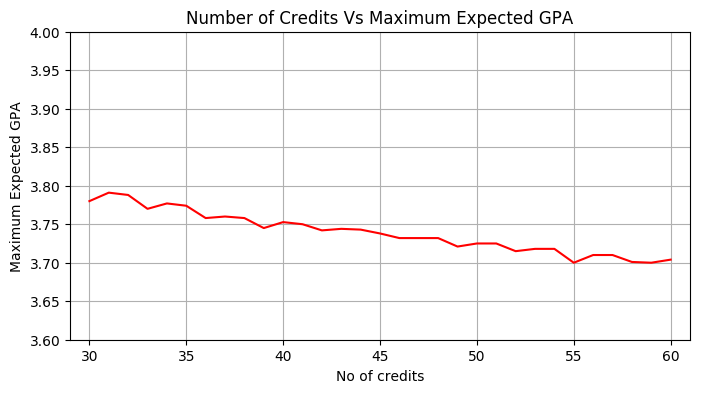

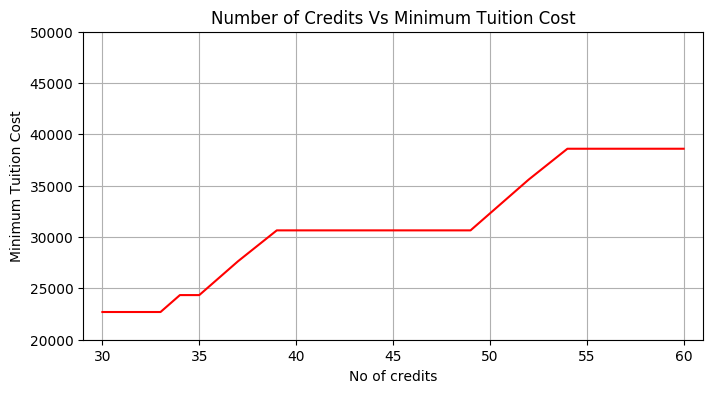

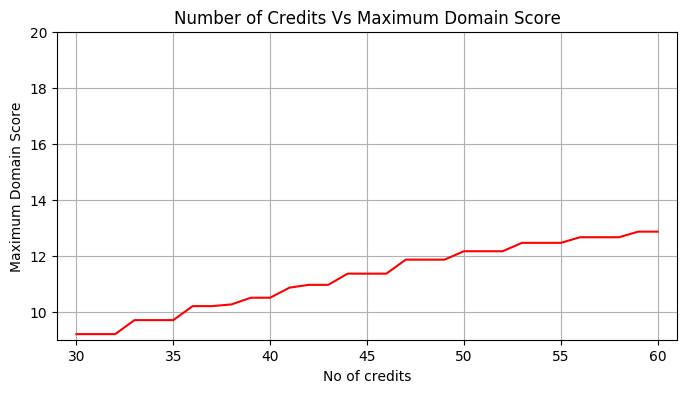

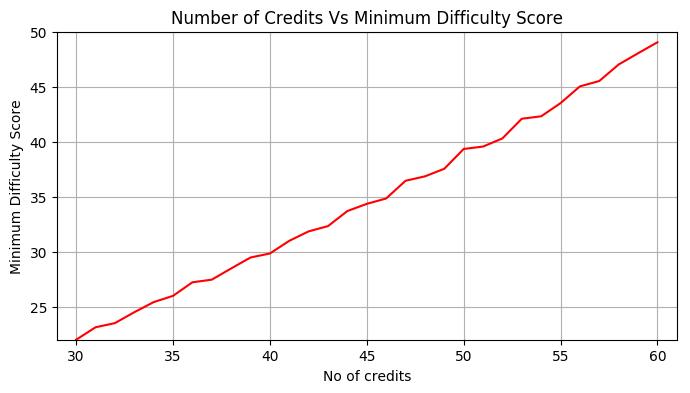

PyObject <matplotlib.text.Text object at 0x131792a10>

In [25]:
credit=[30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]
gpa=[3.78,3.791,3.788,3.77,3.777,3.774,3.758,3.76,3.758,3.745,3.75275,3.75,3.742,3.744,3.743,3.738,3.732,3.732,3.732,
    3.721,3.725,3.725,3.715,3.718,3.718,3.70,3.710,3.710,3.701,3.70,3.704]
tuition_cost=[22699.4,22699.4,22699.4,22699.4,24347.58,24347.58,25995.76,27643.94,29147.34,30650.74,30650.74,30650.74,
30650.74,30650.74,30650.74,30650.74,30650.74,30650.74,30650.74,30650.74,32298.92,33947.10,35595.28,37098.68,38602.08
,38602.08,38602.08,38602.08,38602.08,38602.08,38602.08]
gain=[9.20,9.20,9.2,9.7,9.7,9.7,10.2,10.2,10.26,10.50,10.50,10.86,10.96,10.96,11.36,11.36,11.36,11.86,11.86,11.86,12.16
,12.16,12.16,12.46,12.46,12.46,12.66,12.66,12.66,12.86,12.86]
difficulty=[22.0,23.13,23.51,24.5,25.42,25.99,27.22,27.46,28.48,29.475,29.84,30.99,31.85,32.33,33.70,34.35,34.84,36.45,36.85
,37.54,39.34,39.56,40.30,42.09,42.31,43.51,45.03,45.52,47.02,48.04,49.04]



using PyPlot

figure(figsize=(8,4))
plot(credit,gpa,"r-", markersize=10)
axis([29,61,3.6,4])
grid("on")
title("Number of Credits Vs Maximum Expected GPA")
xlabel("No of credits")
ylabel("Maximum Expected GPA")


using PyPlot
figure(figsize=(8,4))
plot(credit,tuition_cost,"r-", markersize=10)
axis([29,61,20000,50000])
grid("on")
title("Number of Credits Vs Minimum Tuition Cost")
xlabel("No of credits")
ylabel("Minimum Tuition Cost")

using PyPlot
figure(figsize=(8,4))
plot(credit,gain,"r-", markersize=10)
axis([29,61,9,20])
grid("on")
title("Number of Credits Vs Maximum Domain Score")
xlabel("No of credits")
ylabel("Maximum Domain Score")

using PyPlot
figure(figsize=(8,4))
plot(credit,difficulty,"r-", markersize=10)
axis([29,61,22,50])
grid("on")
title("Number of Credits Vs Minimum Difficulty Score")
xlabel("No of credits")
ylabel("Minimum Difficulty Score")

From the figures, we guess that the presence of too many local optima in GPA maximization constraint makes it a harder problem to solve.

### 4.C. Limitation of the model

### Works on a reduced number of parameters :
Our model considers a restricted subset of the constraints that would apply to this problem in real time. In an ideal case, gain that a student gets from a set of courses depends highly on the correlation between the set of courses under consideration. In that way, a student will be able to appreciate the subjects better. Also, we assume that a course has only one section in a given semester. In reality, a course has several sections in a given semester. That leaves multiple options for the student to consider.

## 5. Conclusion ##

In this project, we solved an optimization problem using techniques learned in class to select the ideal set of courses based on his or her preferences to graduate. In real time, the objectives tend to become more specific based on the student's idea of the graudate program.

For example, a student may be interested in completing a selected set of courses. We could think of modelling this as a "Set Cover" problem by finding the smallest set of courses that includes a student's preferred courses. Or, if a student tends to complete a course within a particular semester. For example, one student wants to finish Machine Learning course before 2nd semester and Operating systems before 3rd semester. This could be modelled as a variant of the Hovercraft problem with minimum overall tuition or maximum GPA. 

As stated, the time taken by the best solver (Gurobi in our case) increases with the size of the course set. We can explore alternative modelling techniques that could improve the solving time. 